# Introduction

*Saccharomyces cerevisiae* is a yeast, a small single-cell eukaryote, known for its fermentation abilities. It has been used for winemaking, baking, and brewing since first emerging civilizations. Thanks to its characteristics, *Saccharomyces cerevisiae* is examined as a convenient model organism.

We are going to study its  gene regulatory network using graph theory and python **networkx** library.

# Exploration and characterization of the gene regulatory network

In [4]:
import networkx as ntx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import pygraphviz as pgv
ntx.__version__

'2.3'

The file *GRN_edges_S_cerevisiae.txt* contains the edges between transcription factors and target genes. We will use it to create our graph. We drop the first column which has no further interest.

In [5]:
network = pd.read_csv("GRN_edges_S_cerevisiae.txt", sep = ',', header=0)
gene = pd.read_table("net4_gene_ids.tsv", sep = '\t')
transcription= pd.read_table('net4_transcription_factors.tsv')
mapping = pd.read_table('go_slim_mapping.tab.txt', header = None)
network = network.drop('Unnamed: 0', axis=1)

We print every dataframe to see its content. *network* contains the relations between transcription factors and target genes, *gene* the name of genes within their ids, *transcription* the list of transcription factors. In *mapping*, we'll use the gene names (first column) and the Gene Ontology annotation (sixth column).

In [14]:
network.head()

KeyError: "['Unnamed: 0'] not found in axis"

In [7]:
gene.head()

,ID,Name
0,G1,YHR084W
1,G2,YER109C
2,G3,YDR496C
3,G4,YBR098W
4,G5,YNL139C


In [8]:
transcription.head()

,transcription_factor
0,G1
1,G2
2,G3
3,G4
4,G5


In [9]:
mapping.head()

,0,1,2,3,4,5,6
0,HRA1,HRA1,S000119380,C,cellular_component,GO:0005575,ncRNA_gene
1,HRA1,HRA1,S000119380,F,molecular_function,GO:0003674,ncRNA_gene
2,HRA1,HRA1,S000119380,P,rRNA processing,GO:0006364,ncRNA_gene
3,HRA1,HRA1,S000119380,P,ribosomal small subunit biogenesis,GO:0042274,ncRNA_gene
4,ICR1,ICR1,S000132612,C,nucleus,GO:0005634,ncRNA_gene


We create our directed graph. It contains 1994 nodes and 3940 edges with average in-degree of 1.9759.

In [10]:
G = ntx.DiGraph()
G = ntx.from_pandas_edgelist(network, 'transcription_factor', 'target_gene', create_using = ntx.DiGraph())
ntx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 1994\nNumber of edges: 3940\nAverage in degree:   1.9759\nAverage out degree:   1.9759'

## Plotting the network

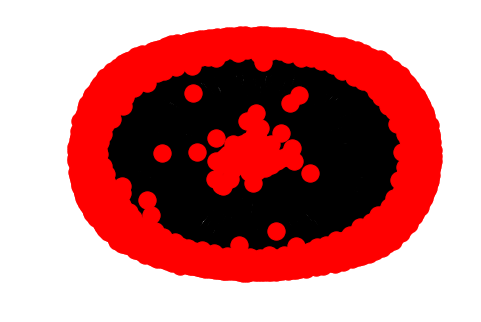

In [8]:
ntx.draw(G)

We draw the network using *draw()* method. This image is not really clear. In order to get a better representation of the graph, we have to find another method.

In [9]:
both_genes = set(network['transcription_factor']).intersection(network['target_gene'])
regulatory_genes = set(network['transcription_factor']) - set(both_genes)
target_genes = set(network['target_gene']) - set(both_genes)

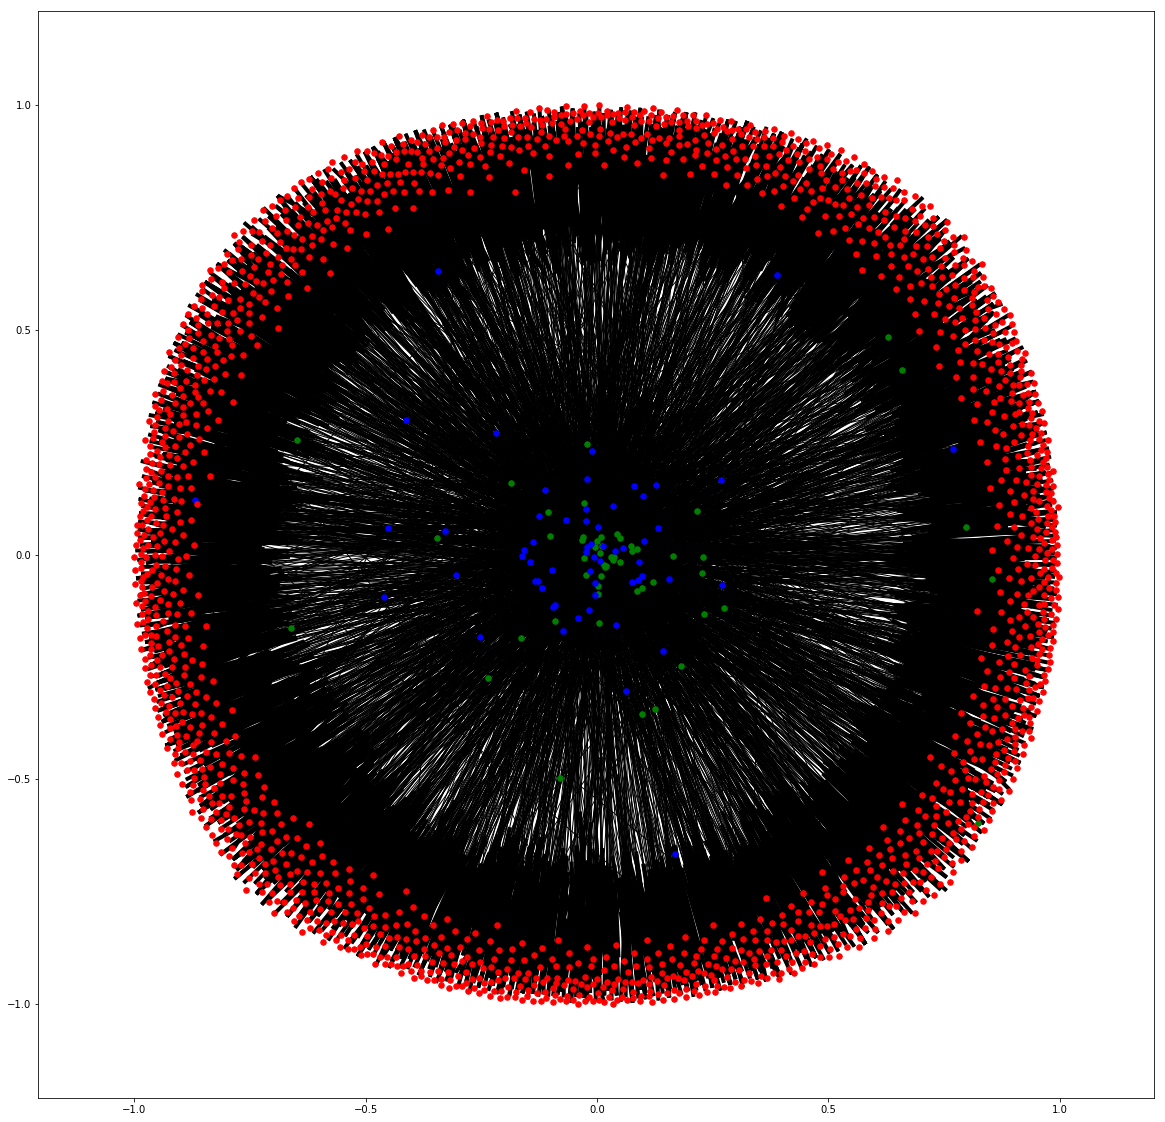

In [10]:
plt.figure(figsize=(20,20))
ntx.draw_networkx_edges(G, pos = ntx.spring_layout(G), edgelist = list(G.edges()))
ntx.draw_networkx_nodes(G, nodelist= list(both_genes), 
                       node_color = 'g',  pos = ntx.spring_layout(G), with_labels = False, node_size = 30)
ntx.draw_networkx_nodes(G, nodelist= list(regulatory_genes), 
                       node_color = 'b',  pos = ntx.spring_layout(G), with_labels = False, node_size = 30)
ntx.draw_networkx_nodes(G, nodelist=list(target_genes) , 
                       node_color = 'r',  pos = ntx.spring_layout(G), with_labels = False, node_size = 30)

Even though this image, created using *ntx.spring_layout*, gives us a better idea about the disposition of factors and genes in the graph, we would like to get a figure that specifies if there are some particular parts in the graph. For that, we'll use the *nx_agraph.graphviz_layout* method.

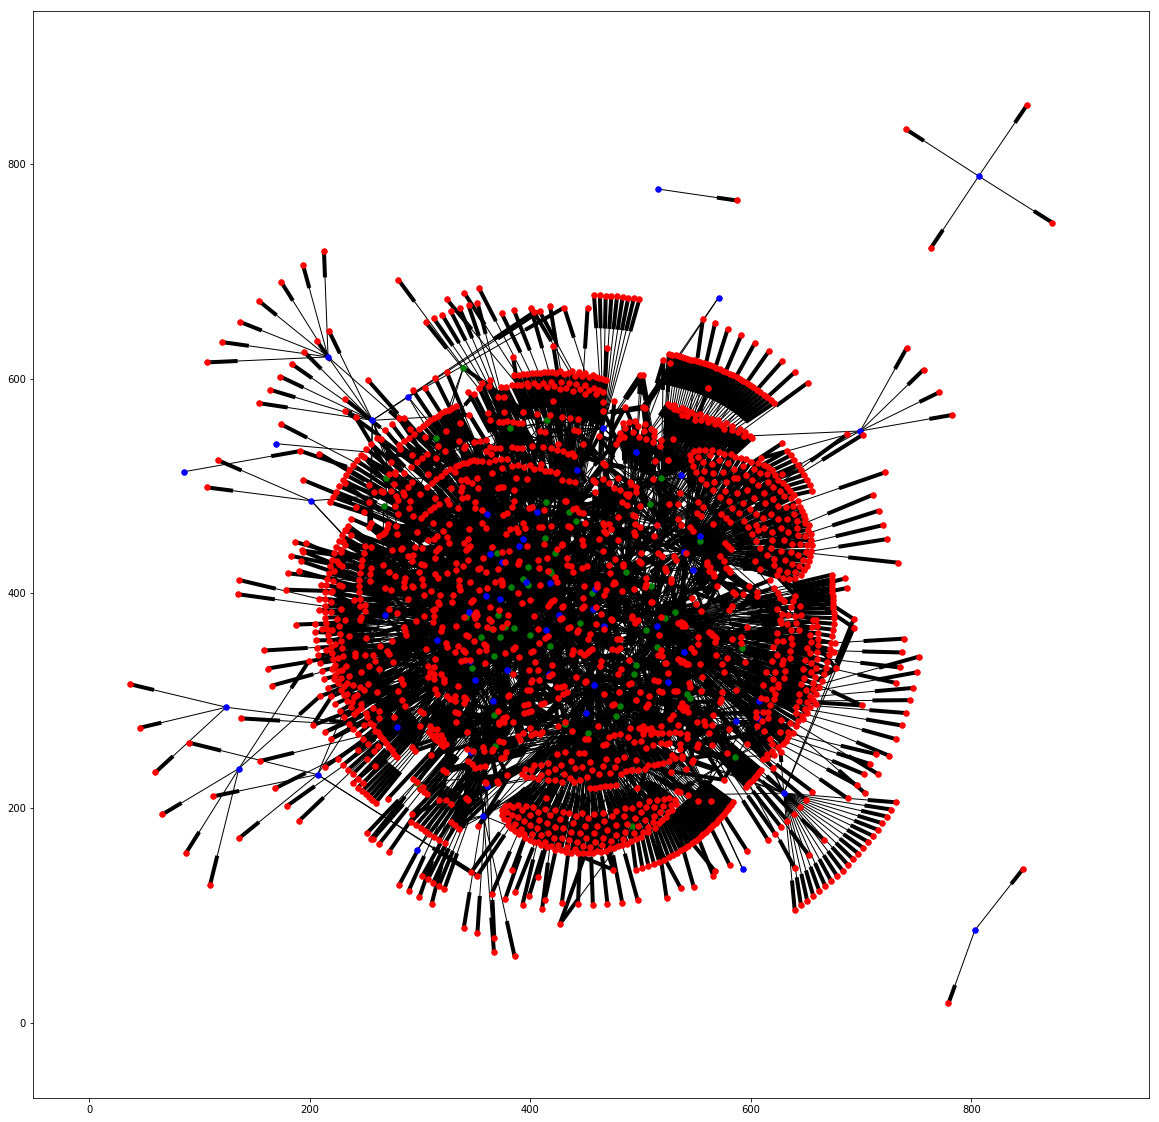

In [11]:
plt.figure(figsize=(20,20))
ntx.draw_networkx_edges(G, pos = ntx.nx_agraph.graphviz_layout(G), edgelist = list(G.edges()))
ntx.draw_networkx_nodes(G, nodelist= list(both_genes), node_color = 'g', \
                        pos = ntx.nx_agraph.graphviz_layout(G), with_labels = False, node_size = 30)
ntx.draw_networkx_nodes(G, nodelist= list(regulatory_genes), node_color = 'b',  \
                        pos = ntx.nx_agraph.graphviz_layout(G), with_labels = False, node_size = 30)
ntx.draw_networkx_nodes(G, nodelist=list(target_genes) , node_color = 'r', \
                        pos = ntx.nx_agraph.graphviz_layout(G), with_labels = False, node_size = 30)

This representation shows the major links between the target genes only (red), transcription factors only (blue) and the genes that accomplish both roles (green). We see that one factor regulates often a whole bunch of genes. In few cases, this relation is unconnected to the rest of the graph.  

We define a new method which perrmits us to use simply *nx_agraph.graphviz_layout()*.

In [12]:
def draw_agraph(G, nodes):
    plt.figure(figsize=(20,20))
    col = ['#084594', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#f7fbff']
    ntx.draw_networkx_edges(G, pos = ntx.nx_agraph.graphviz_layout(G), edgelist = list(G.edges()))
    for i in range(len(nodes)):
        ntx.draw_networkx_nodes(G, pos = ntx.nx_agraph.graphviz_layout(G), \
                                nodelist = nodes[i], node_color = col[i], \
                                with_labels = False, node_size = 30)

## Network metrics

#### Clustering coefficient

To calculate the clustering coefficient of a node, we use the following formula :

$C = {\frac {\mbox{number of closed triplets}}{\mbox{number of all triplets (open and closed)}}}$

In [13]:
clust_coef = ntx.average_clustering(G)
clust_coef

0.04436303023690503

The clustering coefficient measures the degree to which nodes in a graph tend to cluster together. In this graph, it is very low : around 0.044. The nodes are not very connected to each other to make clusters.

#### Betweenness centrality

(array([1.973e+03, 4.000e+00, 4.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.        , 0.00010273, 0.00020546, 0.00030819, 0.00041092,
        0.00051365, 0.00061638, 0.00071911, 0.00082184, 0.00092457,
        0.00102729, 0.00113002, 0.00123275, 0.00133548, 0.00143821,
        0.00154094, 0.00164367, 0.0017464 , 0.00184913, 0.00195186,
        0.00205459]),
 <a list of 20 Patch objects>)

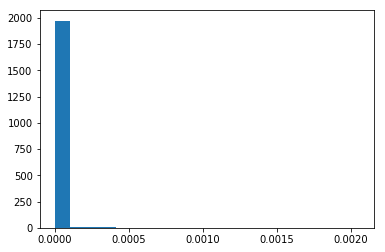

In [26]:
btw_ctr = ntx.betweenness_centrality(G)
plt.hist(btw_ctr.values(), bins=20)

Betweeness centality is defined as the number of shortest paths, among any pair of nodes, passing by a given vertex (node). 

We can see that in our case it is often very low. Majority of nodes (cca 1973 of 1994) figures in a very small number of shortest paths (0 or 1). 

#### Degrees in and out

In [35]:
adj_G = ntx.to_numpy_matrix(G, nodelist=G.nodes())
adjacency = pd.DataFrame(adj_G)
in_degree = adjacency.sum(axis=0).sort_values() 
out_degree = adjacency.sum(axis=1).sort_values() 

14.0


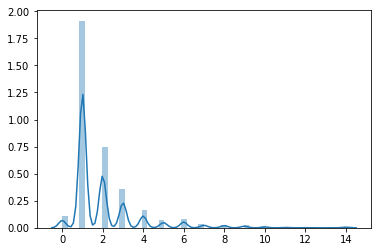

In [37]:
print(max(in_degree))
sns.distplot(in_degree)

The histogram of in-degree seems to follow the Chi-squared distribution. Most of nodes has only one incoming edge (final point of the regulatory network). Quantity of nodes having others incoming edges decreases with the maximum of 14.

217.0


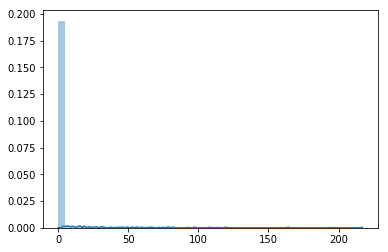

In [39]:
print(max(out_degree))
sns.distplot(out_degree)

As expected, majority of the network has no out-coming edge (corresponds to the target genes only). The regulation is thus compised in a small comunity of genes and factors (which was also clear in the plots). Maximum of the out-degree is 217, so there is a gene (factor) regulating 217 other genes!

## K-shell decomposition

K–shell (or k–core) decomposition is an algorithm for analyzing the structure of large–scale graphs and it provides a method for identifying hierarchies in a network. 

The *k-shell* instance provides us a list of lists where the nodes in each layer has a degree corresponding to its index (and the nodes getting this degree by removing other nodes recursively).

The *k-core* instance is a list of lists containing the nodes surviving in the graph after the removal.

('k', 1)
('nb of nodes', 941)
('k', 2)
('nb of nodes', 524)
('k', 3)
('nb of nodes', 293)
('k', 4)
('nb of nodes', 184)
('k', 5)
('nb of nodes', 112)
('k', 6)
('nb of nodes', 55)
('k', 7)
('nb of nodes', 0)


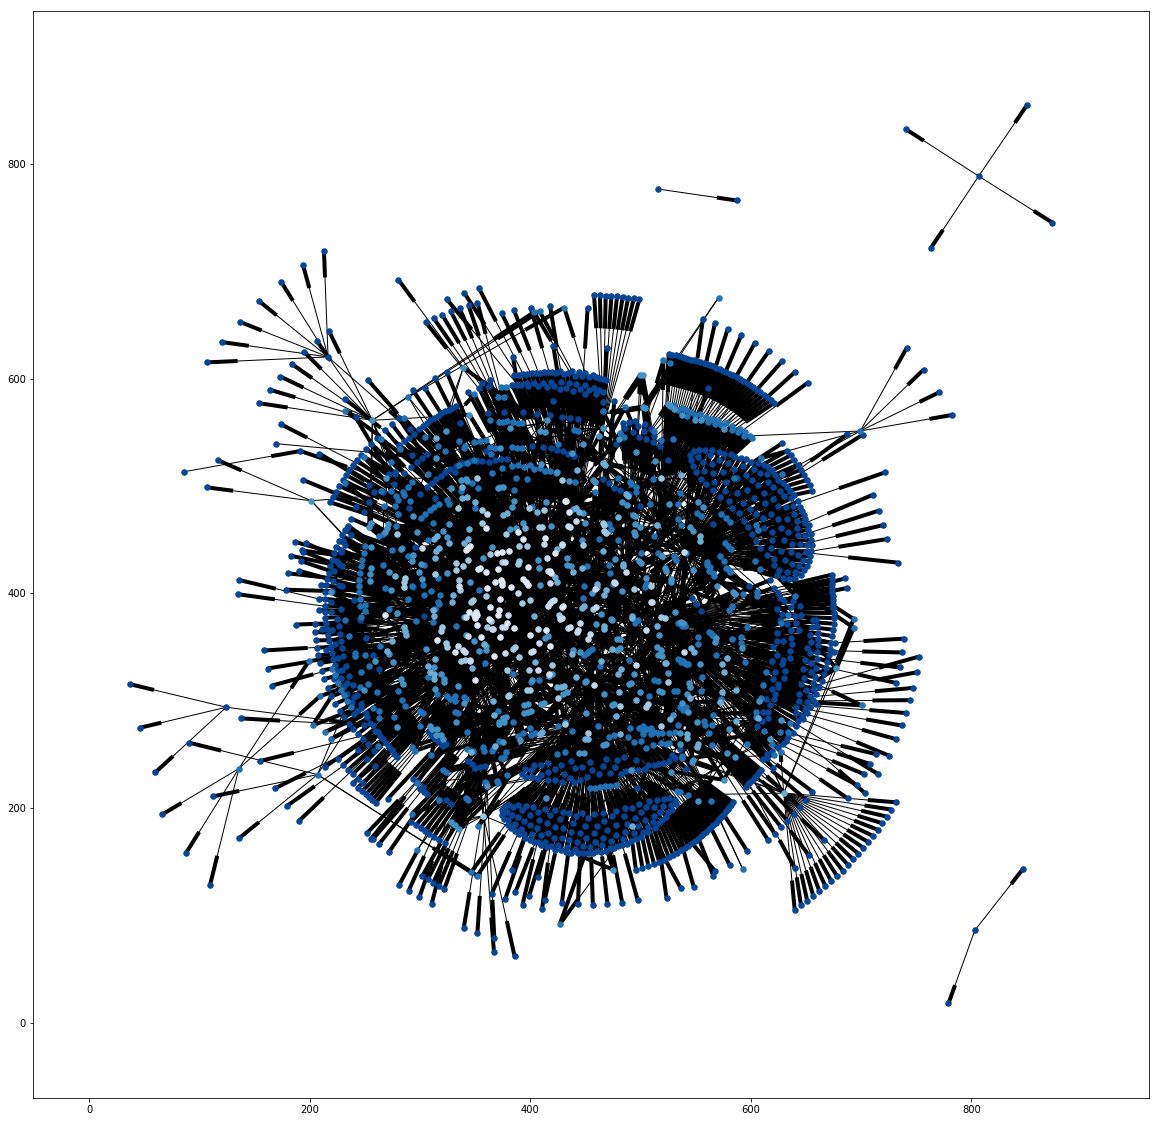

In [38]:
def k_shell(G):
    k = 1
    G_ = G.copy()
    k_shell = []
    k_core = []
    
    degrees = list(G_.degree())
    only_deg = []
    for i in range(len(degrees)):
        only_deg.append(degrees[i][1])
    
    while G_.number_of_nodes() > 0:
        while True in [True for c in range(k+1) if c in only_deg]:
            for n, d in list(G_.degree()):
                if d <= k :
                    if len(k_shell) >= k:
                        k_shell[k-1].append(n)
                    else:
                        k_shell.append([n])
                    G_.remove_node(n)
            
            degrees = list(G_.degree())
            only_deg = []
            for i in range(len(degrees)):
                only_deg.append(degrees[i][1])
                
        k_core.append(list(G_.nodes()))
        print("k", k)
        print("nb of nodes", G_.number_of_nodes()) 
        k = k+1
    return k_core, k_shell
                
G_core = k_shell(G)[1]
draw_agraph(G, G_core)

Nodes colored in blue are in the first layers of the k-shell, they have been removed in first so they are not in the core of the graph. Nodes in white form the true heart of the graph - they have been removed in the last moments of the decomposition.

# Community detection

### Girvan–Newman algorithm

The Girvan-Newman algorithm is a method used to find communities in complex graphs. The goal of this method is to identify the edges probably binding communities, and to remove them in order to get individual communities.

The algorithm works this way:
- calculate the betweenness of all edges in the graph
- remove the edges having the highest betweenness
- calculate again the betweenness of the edges 
- get back to the second and third step

Indeed, the first edges to be removed will have the highest betweenness, and so will be used a lot to make a shortest path between two nodes of the graph. We can say then that the edges are used as bridges between the different communities, and many are crossed to go from one side of the cluster to another.

In [150]:
import itertools

k = 1
comp = ntx.algorithms.community.centrality.girvan_newman(G)

In [17]:
for communities in itertools.islice(comp, k):
    print(tuple(sorted(c) for c in communities))

KeyboardInterrupt: 

In [46]:
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
print(type(limited))

<type 'itertools.takewhile'>


In [47]:
for communities in limited:
    print(communities) 

['G1375', 'G220', 'G2303', 'G4322', 'G745'], 

['G1468', 'G1834', 'G184', 'G2263', 'G231', 'G2537', 'G2970', 'G4726', 'G4869']

In [147]:
print(tuple(comm_list))

(<generator object <genexpr> at 0x7f91f4c64910>,)


NetworkXError: Node <generator object <genexpr> at 0x7f91f4c64910> has no position.

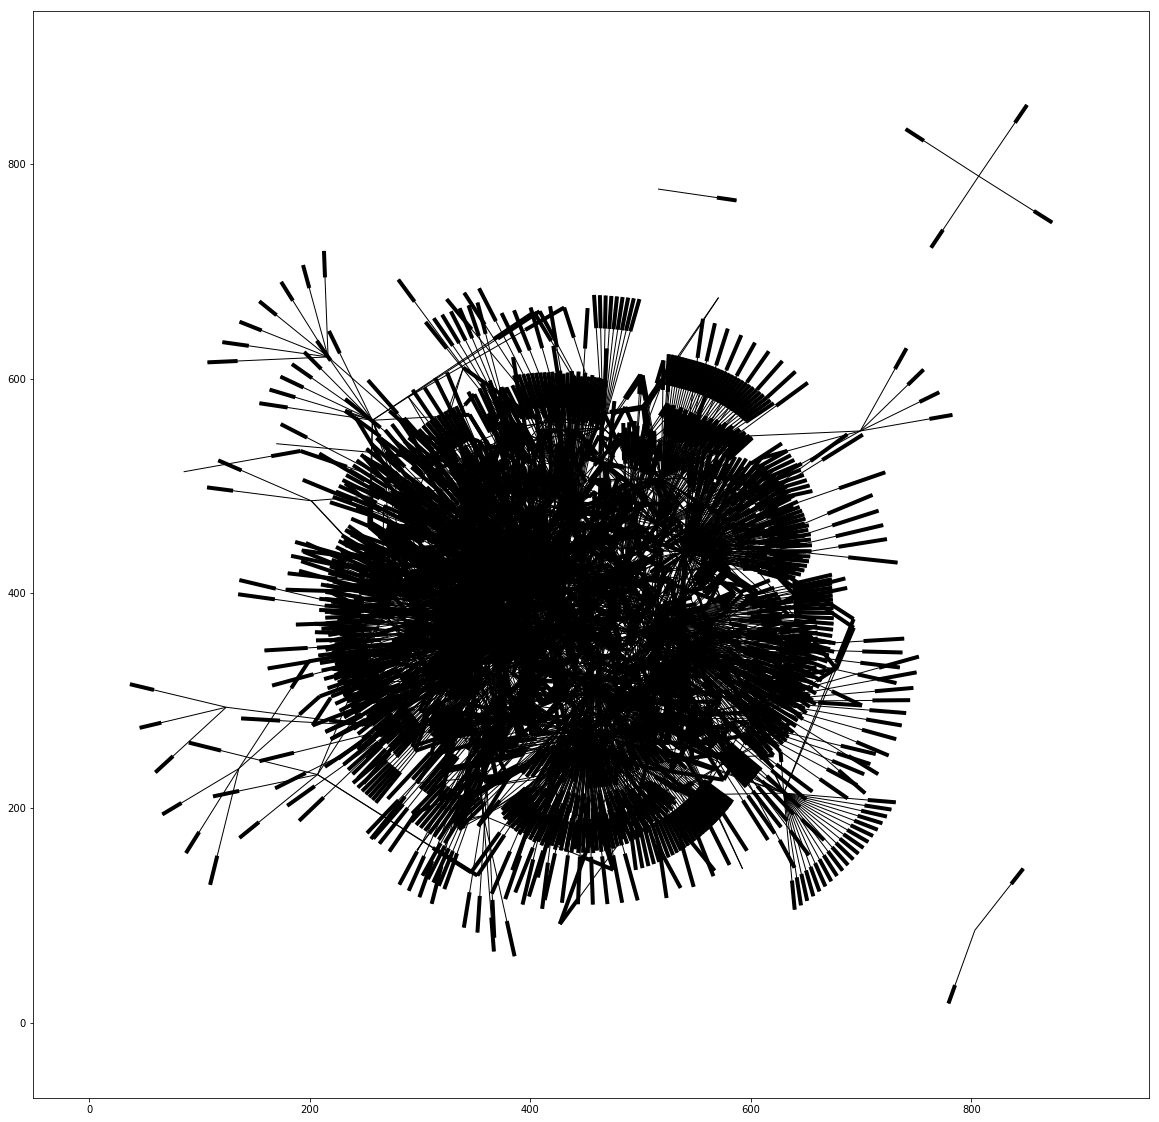

In [97]:
draw_agraph(G, [comm_list])

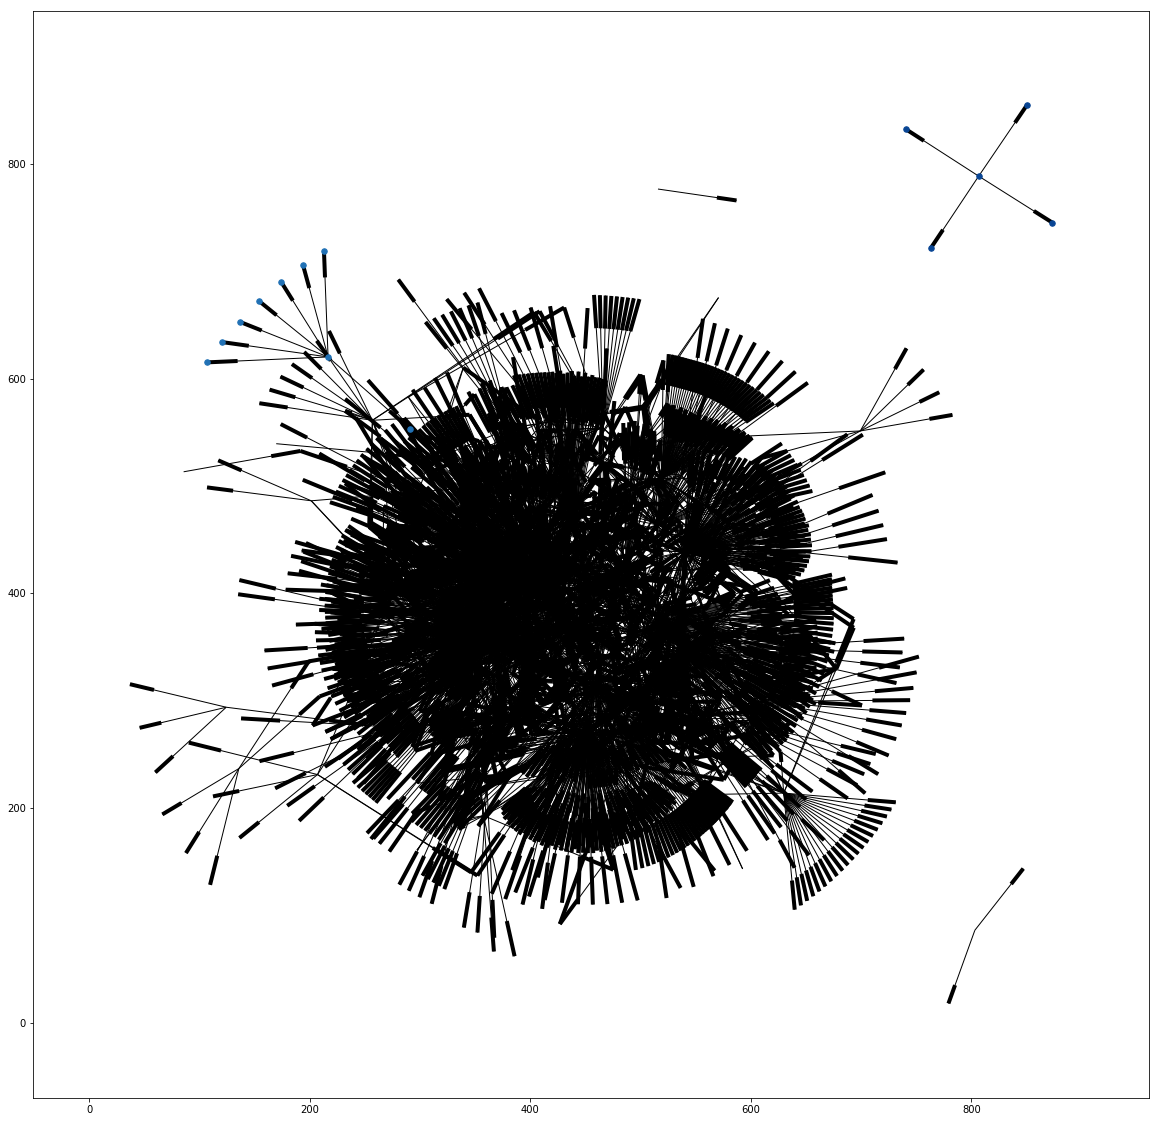

In [54]:
some_comms = []
some_comms.append(['G1375', 'G220', 'G2303', 'G4322', 'G745'])
some_comms.append(['G1468', 'G1834', 'G184', 'G2263', 'G231', 'G2537', 'G2970', 'G4726', 'G4869'])
draw_agraph(G, some_comms)

In [ ]:
(ntx.draw_circular(G.subgraph(comm), with_labels= True) for comm in comm_list)

commun1 = G.subgraph(['G1375', 'G220', 'G2303', 'G4322', 'G745'])
ntx.draw_circular(commun1, with_labels= True)

###  Louvain algorithm 

Louvain algorithm is a hierarchic method used for community detection based on optimization of modularity. Modularity is a value between -1 and 1 that measures the density of edges inside communities to edges outside communities.

In the Louvain Method, first small communities are found by optimizing modularity locally on all nodes, then each small community is grouped into one node and the first step is repeated. 

In [20]:
ntx.community.best_partition(G)

AttributeError: 'module' object has no attribute 'best_partition'

# Conclusion